# Dynamic Time Warping (DTW)

    “Dynamic Time Warping (DTW) stands out as a beacon in the analysis of time series, offering a tailored approach to measure similarities between temporal sequences.”
    
<b>DTW</b> operates by constructing a matrix where each cell represents the distance between points in two time series. Imagine two sequences laid out on the vertical and horizontal axes of a grid. DTW systematically fills this grid, calculating the cumulative distance between various points, taking into account the cost of aligning each pair of points.

Suppose we have two time series:

Sequence A = [1,2,3,4,5]

Sequence B = [2,3,4]

We calculate the differences of each value within the matrix, which is the distance. (by finding the absolute value of the difference of the distance)

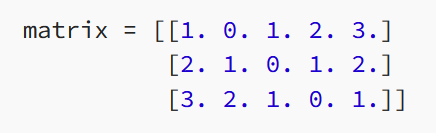

So, the first row in the matrix for example ([1, 0, 1, 2, 3]) are simply the differences between the first value of Sequence B, which is 2, with all values of Sequence A (1, 2, 3, 4, 5), i.e., the difference between 1 and 2 is 1, between 2 and 2 is 0, and so on.

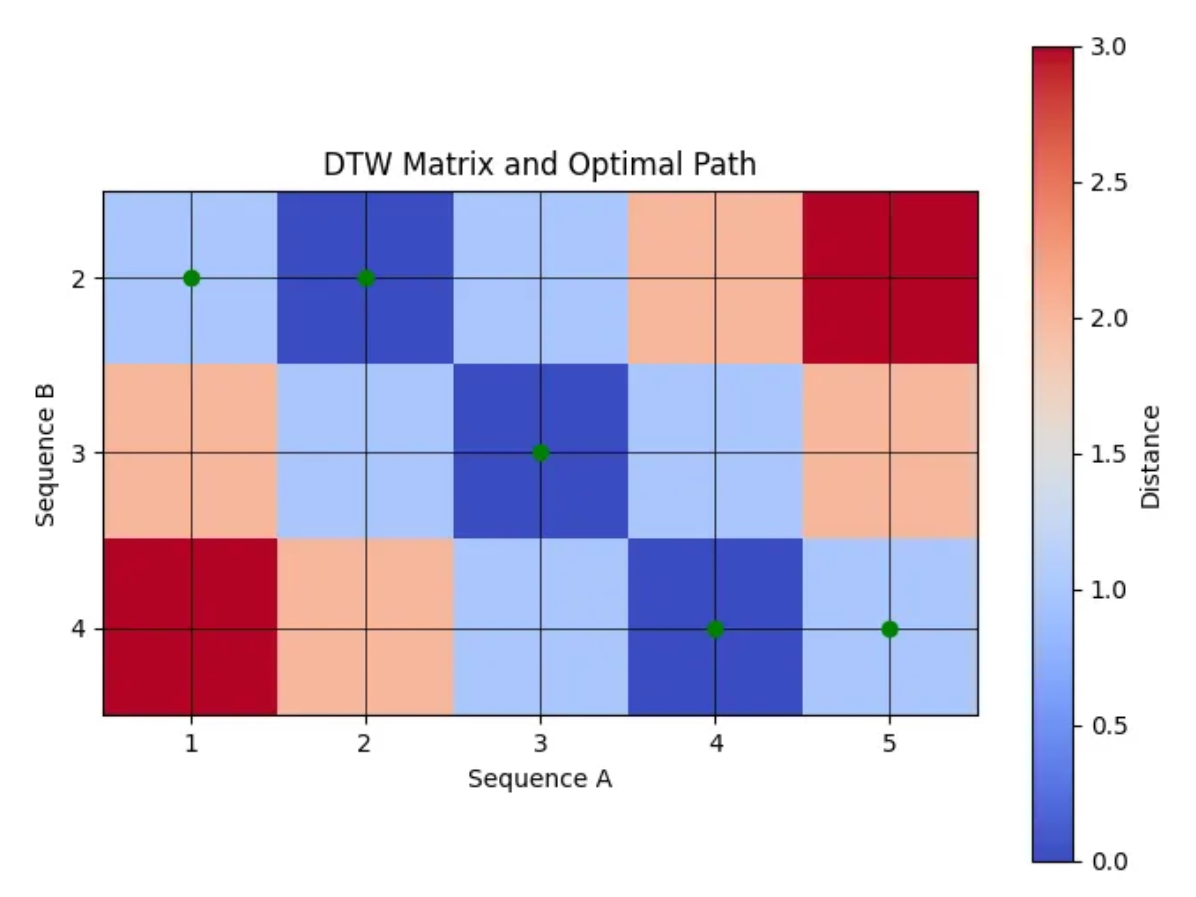

This chart is merely a heatmap as a visualization layer laid above the calculated matrix. The green dots show the minimum distances between the two sequences. The cumulative distance is 1 + 0 + 0 + 0 + 1 = 2. These cumulative distances can then be embeded into a symmetric matrix of cumulative distances. In this example, such a matrix would look like this:

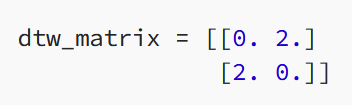

# Hierarchical Clustering

    “Hierarchical Clustering emerges as a natural ally to Dynamic Time Warping in the quest for uncovering the hidden structures within time series data.”

 Hierarchical Clustering builds a dendrogram, a tree-like structure that represents data relationships at different levels of granularity. 

<b>Initial Clusters</b>

- Clusters 1: Each time series starts as its own cluster.
- Clusters: {A}, {B}, {C}, {D}

<b>Merge 1: Closest Pair</b>

- Objective: Find the closest pair (the smallest non-zero distance in the matrix).
- Distances: DTW(A, B) and DTW(B, C) both are 1, the smallest distances. For simplicity, we merge A and B first.
- Result: New Cluster {AB}
- Clusters 2: {AB}, {C}, {D}

<b>Recalculate Distances (using average linkage)</b>

- Distances:
- DTW(AB, C): Average of DTW(A, C) and DTW(B, C) = (2 + 1) / 2 = 1.5
- DTW(AB, D): Average of DTW(A, D) and DTW(B, D) = (4 + 3) / 2 = 3.5

<b>Merge 2: Forming {ABC}</b>

- Objective: Merge {AB} and {C} as they are the closest.
- Result: New Cluster {ABC}
- Clusters 3: {ABC}, {D}

<b>Recalculate Distances</b>

- Distances:
- DTW(ABC, D): Considering distances from {A, B} to {D} and including {C} to {D}. Since DTW(C, D) is already 3, the presence of {C} doesn't significantly change the average distance to {D} from the {AB} cluster. Approximate remains around 3.5.

<b>Final Merge: Uniting All Series</b>

- Objective: Merge the remaining clusters {ABC} and {D}.
- Result: Final Cluster {ABCD}

<b>The Hierarchical Clustering process</b> can be visualized in a dendrogram, showing the merges:

- First, A and B merge (distance 1).

- Then, the {AB} cluster merges with C (distance 1.5).

- Finally, {ABC} merges with D (approximate distance 3.5).

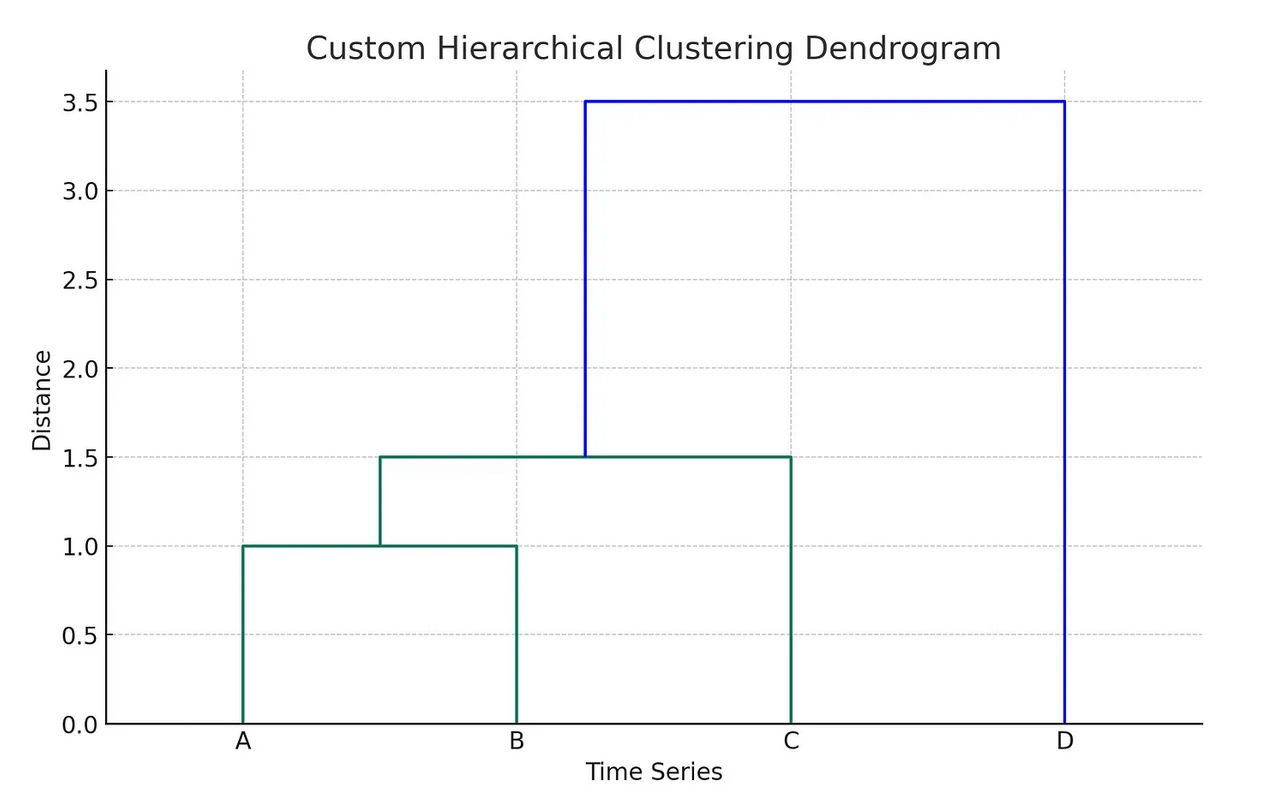

In [2]:
!pip install -q fastdtw yfinance --upgrade

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime

from fastdtw import fastdtw

from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings 
# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 

# Real man Clustering on SET100

In [21]:
start_SET100 = datetime.datetime(2023, 1, 1)
end_SET100 = datetime.datetime(2024, 1, 1)

In [22]:
tickers_SET100 = list(["AAV.BK", "ACE.BK", "ADVANC.BK", "AMATA.BK", 
                "AOT.BK", "AP.BK", "AURA.BK", "AWC.BK", 
                "BAM.BK", "BANPU.BK", "BBL.BK", "BCH.BK",
                "BCP.BK", "BCPG.BK", "BDMS.BK", "BEM.BK",
                "BGRIM.BK", "BH.BK", "BLA.BK", "BSRC.BK",
                "BTG.BK", "BTS.BK", "BYD.BK", "CBG.BK",
                "CENTEL.BK", "CHG.BK", "CK.BK", "CKP.BK",
                "COM7.BK", "CPALL.BK", "CPF.BK", "CPN.BK",
                "CRC.BK", "DELTA.BK", "DOHOME.BK", "EA.BK",
                "EGCO.BK", "ERW.BK", "FORTH.BK", "GLOBAL.BK",
                "GPSC.BK", "GULF.BK", "GUNKUL.BK", "HANA.BK",
                "HMPRO.BK", "INTUCH.BK", "IRPC.BK", "IVL.BK",
                "JMART.BK", "JMT.BK", "KBANK.BK", "KCE.BK",
                "KKP.BK", "KTB.BK", "KTC.BK", "LH.BK",
                "MBK.BK", "MEGA.BK", "MINT.BK", "MTC.BK",
                "NEX.BK", "OR.BK", "ORI.BK", "OSP.BK",
                "PLANB.BK", "PSL.BK", "PTG.BK", "PTT.BK",
                "PTTEP.BK", "PTTGC.BK", "RATCH.BK", "RCL.BK",
                "SABUY.BK", "SAWAD.BK", "SCB.BK", "SCC.BK",
                "SCGP.BK", "SIRI.BK", "SJWD.BK", "SNNP.BK",
                "SPALI.BK", "SPRC.BK", "STA.BK", "STEC.BK",
                "STGT.BK", "TASCO.BK", "TCAP.BK", "THANI.BK",
                "THG.BK", "TIDLOR.BK", "TIPH.BK", "TISCO.BK",
                "TLI.BK", "TOP.BK", "TQM.BK", "TRUE.BK",
                "TTB.BK", "TU.BK", "VGI.BK", "WHA.BK"
               ])
tickers_SET100[:10]

['AAV.BK',
 'ACE.BK',
 'ADVANC.BK',
 'AMATA.BK',
 'AOT.BK',
 'AP.BK',
 'AURA.BK',
 'AWC.BK',
 'BAM.BK',
 'BANPU.BK']

In [26]:
closing_prices_SET100 = pd.DataFrame()

for stock in tickers_SET100:
    ticker = yf.Ticker(stock)
    hist = ticker.history(start=start_SET100, end=end_SET100)
    closing_prices_SET100[stock] = hist['Close']

In [28]:
closing_prices_SET100.head(5)

,AAV.BK,ACE.BK,ADVANC.BK,AMATA.BK,AOT.BK,AP.BK,AURA.BK,AWC.BK,BAM.BK,BANPU.BK,...,TIPH.BK,TISCO.BK,TLI.BK,TOP.BK,TQM.BK,TRUE.BK,TTB.BK,TU.BK,VGI.BK,WHA.BK
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-03 00:00:00+07:00,3.08,2.68,183.103973,20.347179,74.550003,10.381660,18.187546,6.240956,14.479752,11.663830,...,44.945126,84.762390,13.960053,50.821964,37.832405,4.86,1.27888,15.708515,4.727384,3.958373
2023-01-04 00:00:00+07:00,3.04,2.66,185.457489,20.347179,74.053001,10.292929,19.257399,6.240956,14.110841,11.141569,...,45.673962,84.762390,13.299780,49.226654,38.784161,4.84,1.28795,15.521509,4.766453,3.864126
2023-01-05 00:00:00+07:00,3.08,2.66,189.223129,19.774023,74.550003,9.849268,18.576582,6.290098,14.018614,11.141569,...,46.888695,84.975365,13.111130,49.226654,39.260044,4.84,1.28795,15.521509,4.610176,3.788728
2023-01-06 00:00:00+07:00,3.08,2.66,189.223129,19.678495,75.047005,10.204197,18.673843,6.290098,14.295297,10.706352,...,47.131645,85.188339,13.111130,49.226654,39.260044,4.90,1.31516,14.866987,4.590641,3.826427
2023-01-09 00:00:00+07:00,3.08,2.64,191.105942,19.965075,74.798500,10.292929,19.062881,6.191815,14.848663,10.880439,...,47.374588,86.466164,12.828156,49.682457,39.022102,4.88,1.31516,15.053994,4.727384,3.807578


In [29]:
closing_prices_SET100.shape

(243, 100)

In [30]:
normalized_data_SET100 = closing_prices_SET100 / closing_prices_SET100.iloc[0]
normalized_data_SET100.dropna(axis=1, inplace=True)

In [31]:
normalized_data_SET100.tail(5)

,AAV.BK,ACE.BK,ADVANC.BK,AMATA.BK,AOT.BK,AP.BK,AURA.BK,AWC.BK,BAM.BK,BANPU.BK,...,TIPH.BK,TISCO.BK,TLI.BK,TOP.BK,TQM.BK,TRUE.BK,TTB.BK,TU.BK,VGI.BK,WHA.BK
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-22 00:00:00+07:00,0.646104,0.541045,1.180842,1.291410,0.808182,0.999894,0.800430,0.551153,0.535032,0.557858,...,0.645231,1.086580,0.685102,1.007468,0.719915,1.059671,1.205909,0.901422,0.393452,1.295574
2023-12-25 00:00:00+07:00,0.636364,0.548507,1.180842,1.279341,0.811536,1.017910,0.805802,0.554321,0.528386,0.549593,...,0.645231,1.089359,0.674722,1.007468,0.713429,1.049383,1.213494,0.913942,0.401914,1.270897
2023-12-26 00:00:00+07:00,0.639610,0.570895,1.170156,1.303479,0.804829,1.026918,0.811174,0.554321,0.525062,0.553725,...,0.650794,1.094917,0.653961,0.998096,0.726401,1.049383,1.221078,0.926461,0.397683,1.295574
2023-12-27 00:00:00+07:00,0.636364,0.559701,1.170156,1.303479,0.808182,1.026918,0.795058,0.563823,0.528386,0.553725,...,0.650794,1.100475,0.640121,1.002782,0.726401,1.039095,1.221078,0.932721,0.399798,1.307913
2023-12-28 00:00:00+07:00,0.646104,0.570895,1.159469,1.291410,0.801475,1.017910,0.827290,0.563823,0.541678,0.561990,...,0.645231,1.108812,0.633201,1.007468,0.745858,1.039095,1.266584,0.938981,0.408260,1.307913


In [32]:
def euclidean(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

dtw_distances = np.zeros((len(normalized_data_SET100.columns), len(normalized_data_SET100.columns)))

for i, stock_i in enumerate(normalized_data_SET100.columns):
    for j, stock_j in enumerate(normalized_data_SET100.columns):
        if i < j:
            series_i = normalized_data_SET100[stock_i].values.flatten()
            series_j = normalized_data_SET100[stock_j].values.flatten()
            distance, path = fastdtw(series_i, series_j, dist=euclidean)
            dtw_distances[i, j] = distance
            dtw_distances[j, i] = distance

Z = linkage(dtw_distances, 'ward')

C:\Users\Alive\AppData\Local\Temp\ipykernel_6628\2679635193.py:15: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dtw_distances, 'ward')


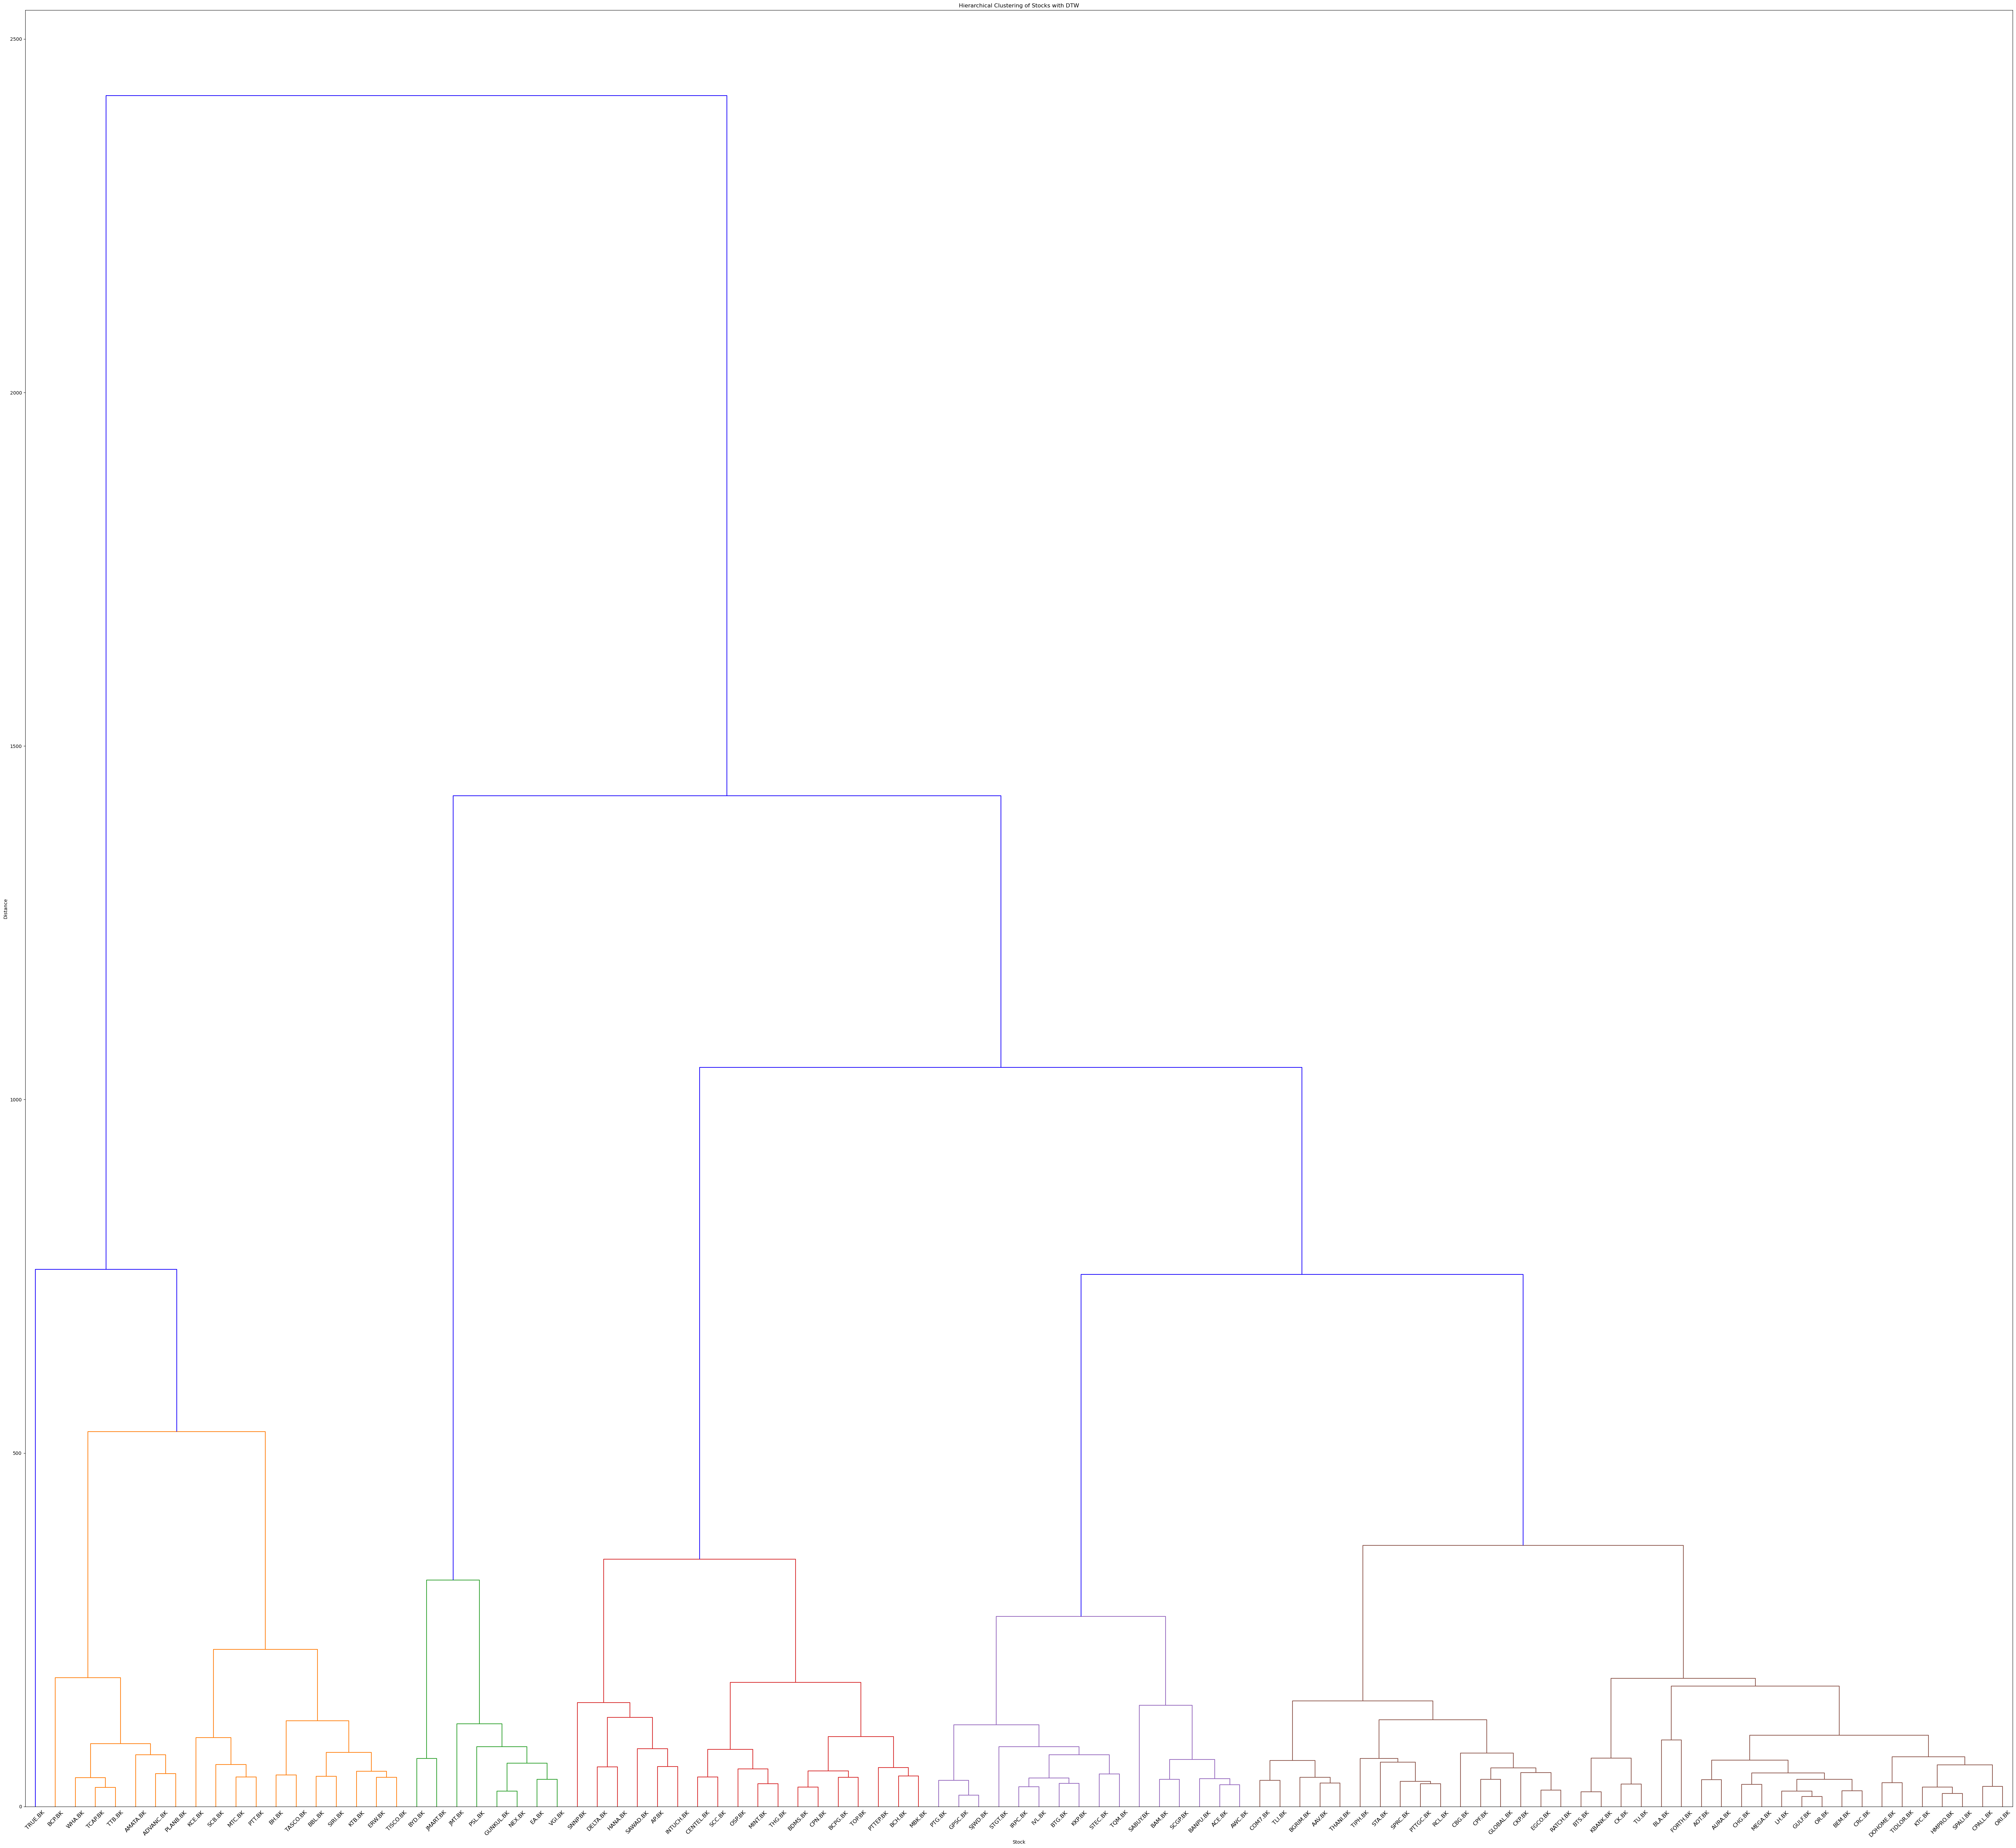

In [36]:
# Plotting
plt.figure(figsize=(60, 55))
dendrogram(Z, labels=normalized_data_SET100.columns, leaf_rotation=45., leaf_font_size=12.,
                    above_threshold_color='#1500fc', color_threshold=0.3 * max(Z[:, 2]),  
                    )
plt.title('Hierarchical Clustering of Stocks with DTW')
plt.xlabel('Stock')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# Example Stock in S&P500

In [9]:
example_stocks = [
    'AAPL',  # Apple
    'JNJ',   # Johnson & Johnson
    'XOM',   # Exxon Mobil
    'HSBC',  # HSBC
    'BABA',  # Alibaba
    'TSLA',  # Tesla
    'KO',    # Coca-Cola
    'SAP',   # SAP
    'NVDA',  # NVIDIA
    'WMT'    # Walmart
]

start_date = '2023-01-01'
end_date = '2024-01-01'

In [10]:
closing_prices = pd.DataFrame()

for stock in example_stocks:
    ticker = yf.Ticker(stock)
    hist = ticker.history(start=start_date, end=end_date)
    closing_prices[stock] = hist['Close']

In [11]:
closing_prices.head(5)

,AAPL,JNJ,XOM,HSBC,BABA,TSLA,KO,SAP,NVDA,WMT
Date,,,,,,,,,,
2023-01-03 00:00:00-05:00,124.048042,170.262558,101.223038,27.376348,90.759949,108.099998,60.540470,101.012199,143.079788,46.825424
2023-01-04 00:00:00-05:00,125.327507,172.116241,101.517647,28.285139,102.541565,113.639999,60.511616,103.839134,147.417679,46.877598
2023-01-05 00:00:00-05:00,123.998444,170.845413,103.789001,29.219900,103.192818,110.339996,59.819180,103.129967,142.580048,46.717819
2023-01-06 00:00:00-05:00,128.560867,172.230896,105.043495,29.695940,105.975410,113.059998,60.973244,105.995773,148.517136,47.862366
2023-01-09 00:00:00-05:00,129.086517,167.768677,103.085747,29.566111,109.359917,119.769997,60.213482,108.259270,156.203384,47.265636


When the dataset is filled with the closing prices, we use Relative Change Normalization to adjust the values to a common scale, which is more interpretable and has richer information for the ongoing clustering process. We divide every value by its first value, so we set the first value to 1 in each column. If a value has e.g. 1.2 after the normalization, this implies that a stock has increased by 20%. Such a normalization process is common in time series like stocks, since it simplifies comparisons, focuses on growth trends and is easy to implement. However, we must also drop NaN values or replace them.

In [12]:
normalized_data = closing_prices / closing_prices.iloc[0]
normalized_data.dropna(axis=1, inplace=True)

In [14]:
normalized_data.head(5)

,AAPL,JNJ,XOM,HSBC,BABA,TSLA,KO,SAP,NVDA,WMT
Date,,,,,,,,,,
2023-01-03 00:00:00-05:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2023-01-04 00:00:00-05:00,1.010314,1.010887,1.002910,1.033196,1.129811,1.051249,0.999523,1.027986,1.030318,1.001114
2023-01-05 00:00:00-05:00,0.999600,1.003423,1.025350,1.067341,1.136986,1.020722,0.988086,1.020965,0.996507,0.997702
2023-01-06 00:00:00-05:00,1.036380,1.011561,1.037743,1.084730,1.167645,1.045883,1.007149,1.049336,1.038002,1.022145
2023-01-09 00:00:00-05:00,1.040617,0.985353,1.018402,1.079987,1.204936,1.107956,0.994599,1.071745,1.091722,1.009401


In [15]:
normalized_data.describe(include='all')

,AAPL,JNJ,XOM,HSBC,BABA,TSLA,KO,SAP,NVDA,WMT
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,1.383891,0.912423,1.036689,1.247234,0.975452,2.011797,0.963668,1.289741,2.555298,1.074149
std,0.140737,0.037449,0.045632,0.081733,0.115241,0.387759,0.036401,0.123135,0.751850,0.058129
min,0.999600,0.835212,0.944590,1.000000,0.775930,1.000000,0.851560,1.000000,0.996507,0.953830
25%,1.298153,0.886939,1.002745,1.176810,0.902832,1.721762,0.947874,1.216989,1.879450,1.026408
50%,1.409000,0.909254,1.028154,1.259537,0.947162,2.054995,0.964816,1.295634,2.927466,1.085148
75%,1.504950,0.933613,1.067875,1.309888,1.030088,2.340611,0.986876,1.343863,3.189638,1.118238
max,1.592847,1.011561,1.156488,1.394037,1.310828,2.713599,1.029281,1.565901,3.522664,1.195904


In [17]:
def euclidean(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

Now we come to the actual part, the DTW and the Hierarchical Clustering. This code does the following: It initializes a DTW distance matrix with zeros in the symmetric shape of the number of stocks defined. Then we iterate over each pair of stocks, extract their time series data and calculate the DTW distance using the euclidean() function. Then we symmetricly store the distance measures and finally, we use scipy´s linkage function to build the hierarchical clusters using the ward method for linkage creation, which minimizes the variance of clusters being merged.

In [18]:
dtw_distances = np.zeros((len(normalized_data.columns), len(normalized_data.columns)))

for i, stock_i in enumerate(normalized_data.columns):
    for j, stock_j in enumerate(normalized_data.columns):
        if i < j:
            series_i = normalized_data[stock_i].values.flatten()
            series_j = normalized_data[stock_j].values.flatten()
            distance, path = fastdtw(series_i, series_j, dist=euclidean)
            dtw_distances[i, j] = distance
            dtw_distances[j, i] = distance

Z = linkage(dtw_distances, 'ward')

C:\Users\Alive\AppData\Local\Temp\ipykernel_6628\2823626438.py:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dtw_distances, 'ward')


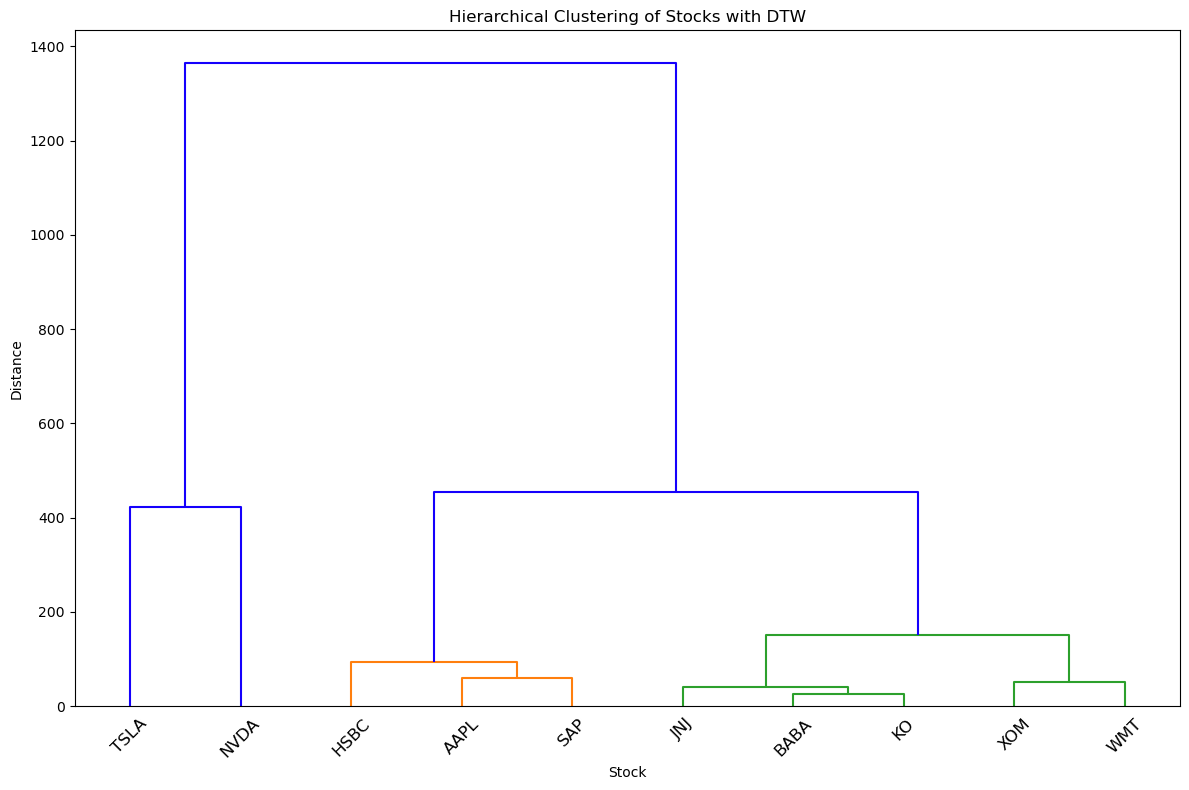

In [20]:
plt.figure(figsize=(12, 8))
dendrogram(Z, labels=normalized_data.columns, leaf_rotation=45., leaf_font_size=12.,
                    above_threshold_color='#1500fc', color_threshold=0.3 * max(Z[:, 2]),  
                    )
plt.title('Hierarchical Clustering of Stocks with DTW')
plt.xlabel('Stock')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

In [37]:
normalized_data.columns

Index(['AAPL', 'JNJ', 'XOM', 'HSBC', 'BABA', 'TSLA', 'KO', 'SAP', 'NVDA',
       'WMT'],
      dtype='object')

In [38]:
normalized_data.values

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.01031427, 1.01088721, 1.00291049, ..., 1.02798607, 1.03031798,
        1.00111422],
       [0.99960017, 1.00342327, 1.0253496 , ..., 1.02096546, 0.99650726,
        0.997702  ],
       ...,
       [1.55296725, 0.90406008, 0.98705175, ..., 1.52425005, 3.45364517,
        1.11621251],
       [1.55642461, 0.90538994, 0.97277906, ..., 1.50890005, 3.46098344,
        1.11402082],
       [1.54798239, 0.90631517, 0.97074002, ..., 1.51144207, 3.46098344,
        1.11458636]])

<Figure size 10000x10000 with 0 Axes>

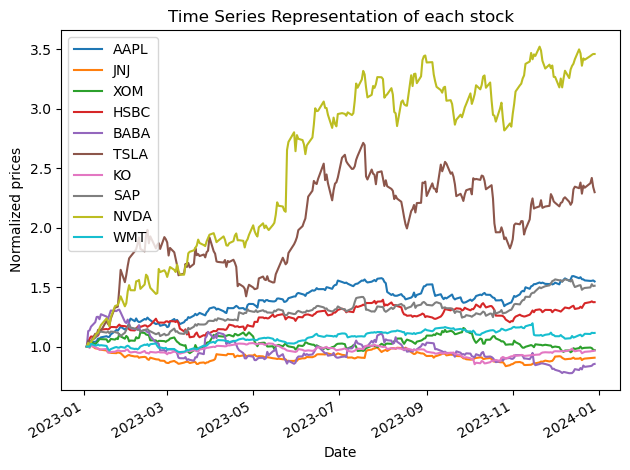

In [47]:
plt.figure(figsize=(100, 100))
normalized_data.plot()
plt.title('Time Series Representation of each stock')
plt.xlabel('Date')
plt.ylabel('Normalized prices')
plt.tight_layout()
plt.show()